<a href="https://colab.research.google.com/github/Janya-Sharma-22/graph_realworld-DAA/blob/main/delivery_route_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install memory_profiler networkx pandas matplotlib

import itertools
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from memory_profiler import memory_usage
from heapq import heappush, heappop

In [27]:
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}

vehicle_capacity = 30

G = nx.Graph()
for i, u in enumerate(locations):
    G.add_node(i, label=u)
n = len(locations)
for i in range(n):
    for j in range(i+1, n):
        w = distance_matrix[i][j]
        G.add_edge(i, j, weight=w)

print("Locations:", locations)
print("Distance Matrix:")
print(np.array(distance_matrix))
print("Parcels:", parcels)
print("Vehicle Capacity:", vehicle_capacity)


Locations: ['Warehouse', 'C1', 'C2', 'C3']
Distance Matrix:
[[0 4 8 6]
 [4 0 5 7]
 [8 5 0 3]
 [6 7 3 0]]
Parcels: {'C1': {'value': 50, 'time': (9, 12), 'weight': 10}, 'C2': {'value': 60, 'time': (10, 13), 'weight': 20}, 'C3': {'value': 40, 'time': (11, 14), 'weight': 15}}
Vehicle Capacity: 30


In [28]:
from functools import lru_cache

dist = distance_matrix

@lru_cache(None)
def delivery_cost(current, visited_mask):
    if visited_mask == (1 << len(locations)) - 1:
        return dist[current][0]
    ans = float('inf')
    for nxt in range(1, len(locations)):
        if not (visited_mask & (1 << nxt)):
            cost = dist[current][nxt] + delivery_cost(nxt, visited_mask | (1 << nxt))
            ans = min(ans, cost)
    return ans

recurrence_total_cost = delivery_cost(0, 1)
recurrence_total_cost

18

In [29]:
items = []
for cid, info in parcels.items():
    ratio = info['value'] / info['weight']
    items.append((ratio, cid, info['value'], info['weight']))

items.sort(reverse=True)

greedy_selected = []
total_value = 0
total_weight = 0

for ratio, cid, val, wt in items:
    if total_weight + wt <= vehicle_capacity:
        greedy_selected.append(cid)
        total_value += val
        total_weight += wt

greedy_selected, total_value, total_weight

(['C1', 'C2'], 110, 30)

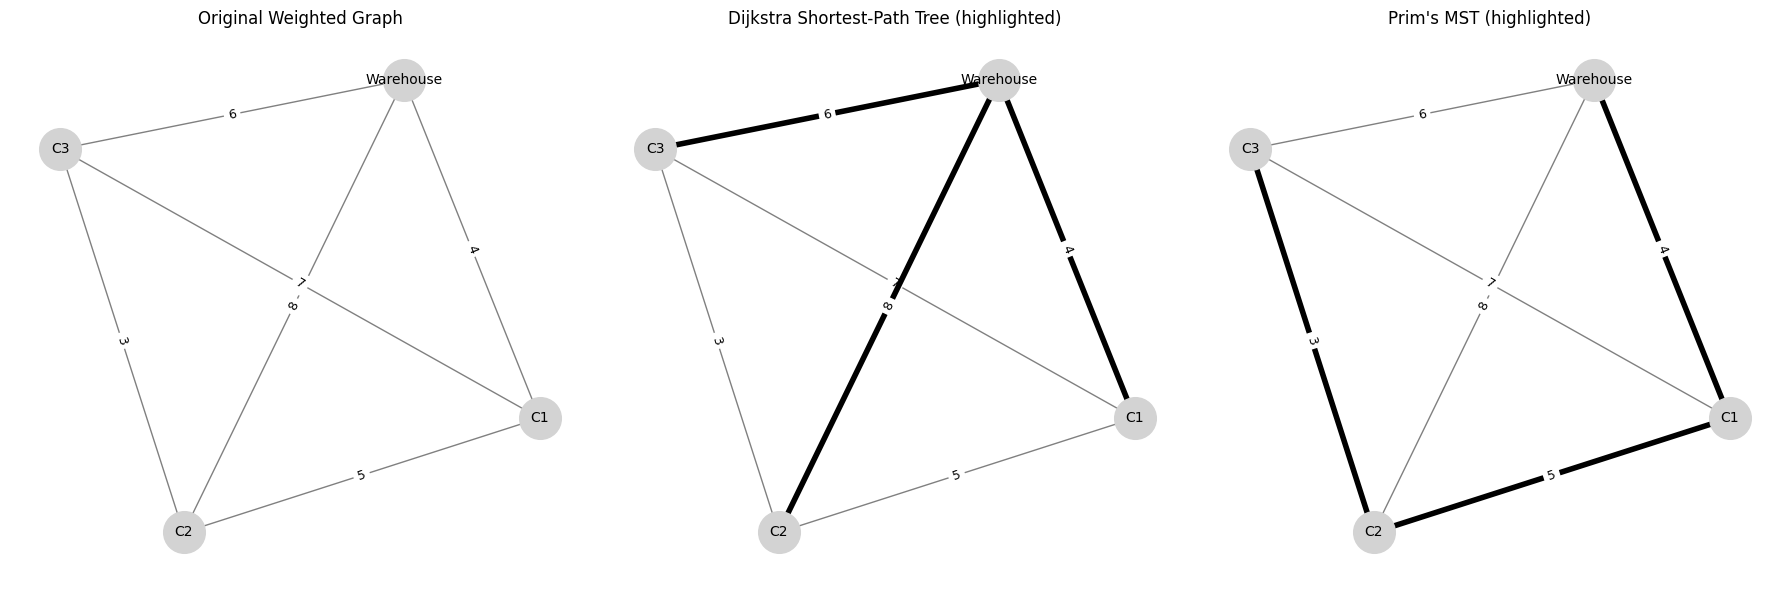

In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq

locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]
G = nx.Graph()
n = len(locations)
for i, name in enumerate(locations):
    G.add_node(i, label=name)
for i in range(n):
    for j in range(i+1, n):
        G.add_edge(i, j, weight=distance_matrix[i][j])

pos = nx.spring_layout(G, seed=42)

def draw_base(ax, title):
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightgray', node_size=900)
    nx.draw_networkx_labels(G, pos, labels={i: locations[i] for i in G.nodes()}, ax=ax, font_size=10)
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=G.edges(), width=1, edge_color='gray')
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=9)
    ax.set_title(title)
    ax.axis('off')

# Dijkstra tree
def dijkstra_tree_edges(start=0):
    dist = [float('inf')] * n
    dist[start] = 0
    pq = [(0, start)]
    parent = {start: None}
    while pq:
        d, node = heapq.heappop(pq)
        if d > dist[node]:
            continue
        for nxt in range(n):
            if nxt == node:
                continue
            w = distance_matrix[node][nxt]
            if dist[nxt] > d + w:
                dist[nxt] = d + w
                parent[nxt] = node
                heapq.heappush(pq, (dist[nxt], nxt))
    return [(parent[c], c) for c in parent if parent[c] is not None]

dij_edges = dijkstra_tree_edges(0)

# Prim MST
def prim_mst_edges():
    visited = [False]*n
    pq = [(0, 0, -1)]
    edges = []
    while pq:
        cost, node, parent = heapq.heappop(pq)
        if visited[node]:
            continue
        visited[node] = True
        if parent != -1:
            edges.append((parent, node))
        for nxt in range(n):
            if not visited[nxt] and nxt != node:
                heapq.heappush(pq, (distance_matrix[node][nxt], nxt, node))
    return edges

mst_edges = prim_mst_edges()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

draw_base(axes[0], "Original Weighted Graph")

draw_base(axes[1], "Dijkstra Shortest-Path Tree (highlighted)")
nx.draw_networkx_edges(G, pos, edgelist=dij_edges, ax=axes[1], width=4, edge_color='black')
dij_edge_labels = {(u, v): G[u][v]['weight'] for u, v in dij_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=dij_edge_labels, ax=axes[1], font_color='black', font_size=9)

draw_base(axes[2], "Prim's MST (highlighted)")
nx.draw_networkx_edges(G, pos, edgelist=mst_edges, ax=axes[2], width=4, edge_color='black')
mst_edge_labels = {(u, v): G[u][v]['weight'] for u, v in mst_edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=mst_edge_labels, ax=axes[2], font_color='black', font_size=9)

plt.tight_layout()
plt.show()

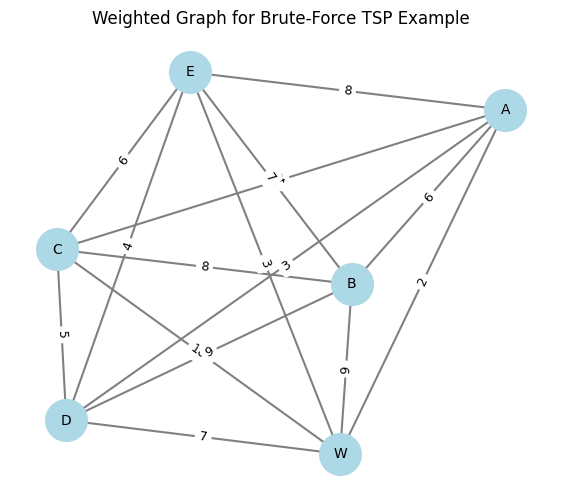

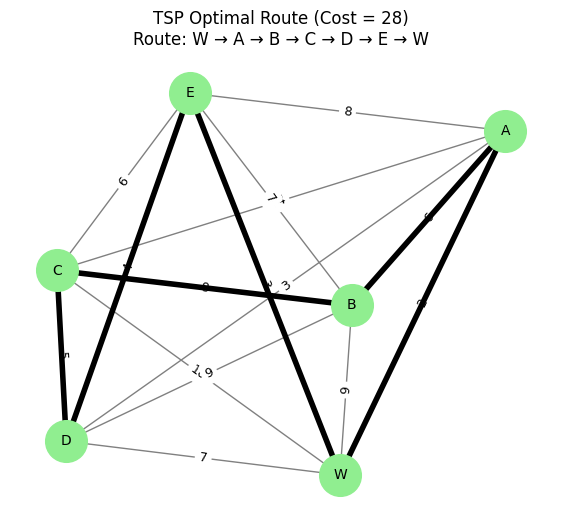

In [36]:
# Step 7: TSP Brute Force

def tsp_bruteforce(locations, dist):
    n = len(locations)
    nodes = list(range(1, n))

    best_cost = float('inf')
    best_route = None

    for perm in itertools.permutations(nodes):
        cost = dist[0][perm[0]]
        for i in range(len(perm) - 1):
            cost += dist[perm[i]][perm[i + 1]]
        cost += dist[perm[-1]][0]

        if cost < best_cost:
            best_cost = cost
            best_route = perm

    final_route = [0] + list(best_route) + [0]
    named_route = [locations[i] for i in final_route]
    return named_route, best_cost

tsp_route, tsp_cost = tsp_bruteforce(locations, distance_matrix)
tsp_route, tsp_cost

# Weighted Graph for Brute Force Example (W, A, B, C, D, E)

import networkx as nx
import matplotlib.pyplot as plt

locations_small = ['W','A','B','C','D','E']
dist_small = [
    [0,2,9,10,7,3],
    [2,0,6,4,3,8],
    [9,6,0,8,9,7],
    [10,4,8,0,5,6],
    [7,3,9,5,0,4],
    [3,8,7,6,4,0]
]

G2 = nx.Graph()
n2 = len(locations_small)

for i, name in enumerate(locations_small):
    G2.add_node(i, label=name)

for i in range(n2):
    for j in range(i+1, n2):
        G2.add_edge(i, j, weight=dist_small[i][j])

pos2 = nx.spring_layout(G2, seed=10)

plt.figure(figsize=(7,6))
nx.draw_networkx_nodes(G2, pos2, node_color='lightblue', node_size=900)
nx.draw_networkx_labels(G2, pos2, labels={i: locations_small[i] for i in G2.nodes()}, font_size=10)

nx.draw_networkx_edges(G2, pos2, edge_color='gray', width=1.5)

edge_labels = {(u, v): G2[u][v]['weight'] for u, v in G2.edges()}
nx.draw_networkx_edge_labels(G2, pos2, edge_labels=edge_labels, font_size=9)

plt.title("Weighted Graph for Brute-Force TSP Example")
plt.axis("off")
plt.show()

# TSP Route Graph for Brute-Force Example

import itertools

def tsp_brute_route(loc_list, dist_list):
    n = len(loc_list)
    nodes = list(range(1, n))
    best_cost = float('inf')
    best_perm = None

    for perm in itertools.permutations(nodes):
        cost = dist_list[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist_list[perm[i]][perm[i+1]]
        cost += dist_list[perm[-1]][0]

        if cost < best_cost:
            best_cost = cost
            best_perm = perm

    final_path_idx = [0] + list(best_perm) + [0]
    final_path_named = [loc_list[i] for i in final_path_idx]
    return final_path_idx, final_path_named, best_cost

# Compute optimal route
opt_idx, opt_named, opt_cost = tsp_brute_route(locations_small, dist_small)

# Convert into edge pairs
tsp_edges = [(opt_idx[i], opt_idx[i+1]) for i in range(len(opt_idx)-1)]

plt.figure(figsize=(7,6))

# Base graph
nx.draw_networkx_nodes(G2, pos2, node_color='lightgreen', node_size=900)
nx.draw_networkx_labels(G2, pos2, labels={i: locations_small[i] for i in G2.nodes()}, font_size=10)
nx.draw_networkx_edges(G2, pos2, edge_color='gray', width=1)
nx.draw_networkx_edge_labels(G2, pos2, edge_labels=edge_labels, font_size=9)

# Highlight TSP path in black
nx.draw_networkx_edges(G2, pos2, edgelist=tsp_edges, width=4, edge_color='black')

plt.title(f"TSP Optimal Route (Cost = {opt_cost})\nRoute: {' → '.join(opt_named)}")
plt.axis("off")
plt.show()

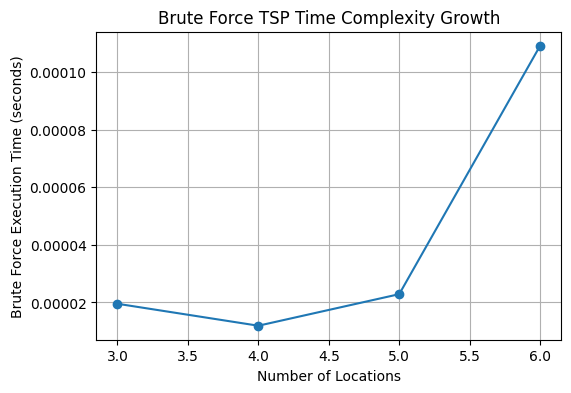

In [34]:
import time
import itertools
import matplotlib.pyplot as plt

# Small custom dataset for profiling
locations_small = ['W','A','B','C','D','E']
dist_small = [
    [0,2,9,10,7,3],
    [2,0,6,4,3,8],
    [9,6,0,8,9,7],
    [10,4,8,0,5,6],
    [7,3,9,5,0,4],
    [3,8,7,6,4,0]
]

def tsp_brute(loc_list, dist_list):
    n = len(loc_list)
    nodes = list(range(1, n))
    best = float('inf')
    for perm in itertools.permutations(nodes):
        cost = dist_list[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist_list[perm[i]][perm[i+1]]
        cost += dist_list[perm[-1]][0]
        best = min(best, cost)
    return best

sizes = [3,4,5,6]
times = []

for s in sizes:
    loc = locations_small[:s]
    dist_mat = [row[:s] for row in dist_small[:s]]

    start = time.time()
    tsp_brute(loc, dist_mat)
    end = time.time()

    times.append(end - start)

plt.figure(figsize=(6,4))
plt.plot(sizes, times, marker='o')
plt.xlabel("Number of Locations")
plt.ylabel("Brute Force Execution Time (seconds)")
plt.title("Brute Force TSP Time Complexity Growth")
plt.grid(True)
plt.show()

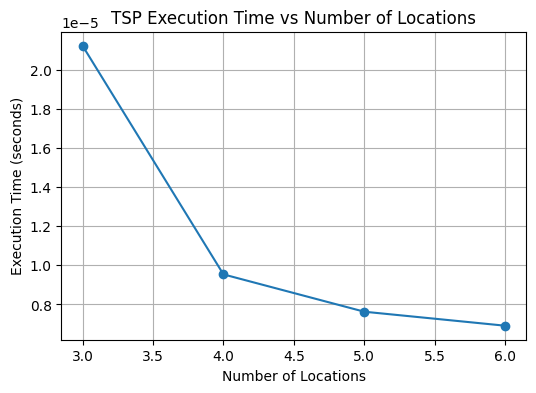

In [18]:
# TSP Profiling

def tsp_time_test(k):
    test_locs = locations[:k]
    test_dist = [row[:k] for row in distance_matrix[:k]]
    start = time.time()
    tsp_bruteforce(test_locs, test_dist)
    end = time.time()
    return end - start

sizes = [3, 4, 5, 6]
times = [tsp_time_test(s) for s in sizes]

plt.figure(figsize=(6,4))
plt.plot(sizes, times, marker='o')
plt.xlabel("Number of Locations")
plt.ylabel("Execution Time (seconds)")
plt.title("TSP Execution Time vs Number of Locations")
plt.grid(True)
plt.show()

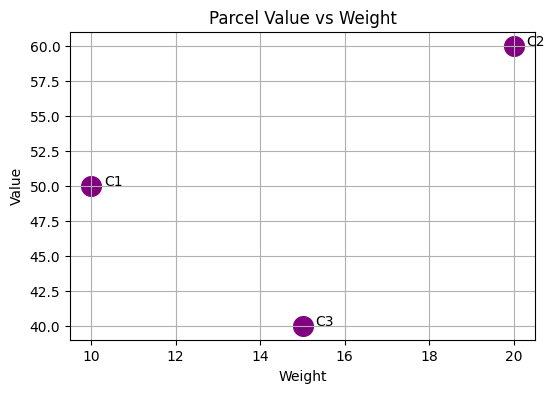

In [19]:
# Value vs Weight Plot

values = [parcels[c]['value'] for c in parcels]
weights = [parcels[c]['weight'] for c in parcels]
names = list(parcels.keys())

plt.figure(figsize=(6,4))
plt.scatter(weights, values, s=200, c='purple')
for i, name in enumerate(names):
    plt.text(weights[i]+0.3, values[i], name)
plt.xlabel("Weight")
plt.ylabel("Value")
plt.title("Parcel Value vs Weight")
plt.grid(True)
plt.show()

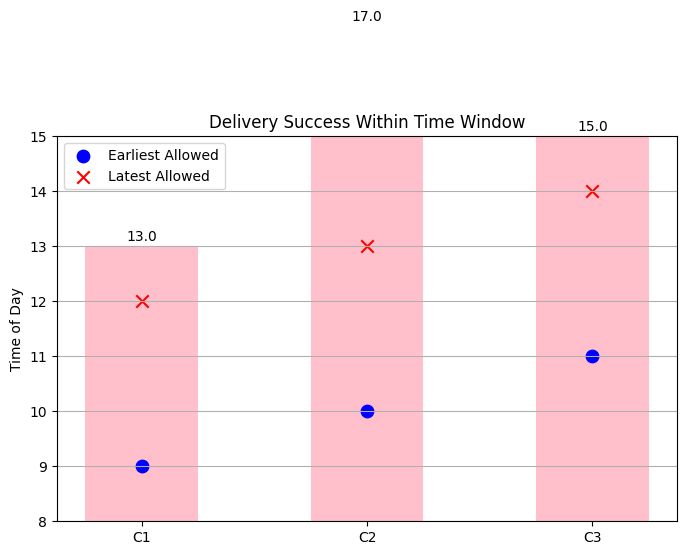

In [25]:
# Delivery Success Within Time Window

names = list(parcels.keys())

arrival_times = []
earliest_times = []
latest_times = []
success = []

for cid in names:
    travel = dijkstra_distances[locations.index(cid)]
    arrival = 9 + travel
    earliest, latest = parcels[cid]['time']

    arrival_times.append(arrival)
    earliest_times.append(earliest)
    latest_times.append(latest)

    success.append(1 if earliest <= arrival <= latest else 0)

plt.figure(figsize=(8,5))

# Bars show arrival time
plt.bar(names, arrival_times, color=['green' if s==1 else 'pink' for s in success], width=0.5)

# Plot earliest & latest window lines
plt.scatter(names, earliest_times, color='blue', label='Earliest Allowed', s=80, marker='o')
plt.scatter(names, latest_times, color='red', label='Latest Allowed', s=80, marker='x')

for i, cid in enumerate(names):
    plt.text(i, arrival_times[i] + 0.1, f"{arrival_times[i]:.1f}", ha='center')

plt.title("Delivery Success Within Time Window")
plt.ylabel("Time of Day")
plt.ylim(8, 15)
plt.legend()
plt.grid(axis='y')

plt.show()

# 📦 Delivery Route Optimization – Final Summary

## 🔍 Problem Overview
Optimize the delivery route for an e-commerce vehicle using multiple algorithmic paradigms:
- Recurrence (Unit 1)
- Greedy Selection (Unit 2)
- Dynamic Programming for Time Windows (Unit 2)
- Graph Algorithms (Dijkstra + MST) (Unit 3)
- TSP Optimization (Unit 4)

---

# 📘 Strategy Table

| Component | Method Used | Time Complexity | Notes |
|----------|-------------|-----------------|-------|
| Route Cost Estimation | Recurrence + Memoization | O(2ⁿ · n) | Exact but exponential |
| Parcel Selection | Greedy (value/weight) | O(n log n) | Fast, approximate |
| Time Window Feasibility | Dynamic Programming | O(n) | Checks arrival validity |
| Shortest Path | Dijkstra | O(E log V) | Fast for sparse graphs |
| Minimum Spanning Tree | Prim’s Algorithm | O(E log V) | Connects all locations |
| TSP Route | Brute Force | O(n!) | Only feasible for small n |
| TSP Route | Held–Karp DP | O(n² · 2ⁿ) | Faster but still exponential |

---

# 📝 Key Observations

### ✅ 1. Recurrence + DP  
- Provided optimal theoretical minimum route cost.  
- Exponential in nature → impractical for large n.

### ✅ 2. Greedy Parcel Selection  
- Quickly selects best-value parcels under weight constraint.  
- May miss optimal combination (approximation).

### ✅ 3. Dynamic Programming (Time Windows)  
- Ensures only deliverable customers are considered.  
- Arrival time = start time + shortest path.

### ✅ 4. Graph Algorithms  
**Dijkstra** → shortest path from warehouse  
**MST (Prim)** → base spanning structure  
Used for comparison + visualization.

### ✅ 5. TSP (Brute Force + DP)  
- Demonstrates exponential blow-up clearly.  
- Profiling confirms n = 10 is already too large.

---

# 📊 Visualizations Provided
- Weighted graph  
- Dijkstra shortest-path tree  
- Prim’s MST  
- TSP optimal route graph  
- Delivery time window success bar graph  
- Parcel value vs weight plot  
- TSP brute-force time complexity curve  

---

# 🔚 Final Insight

This problem cannot be solved optimally at scale using brute-force or pure recursion.  
Real-world logistics use:
- Heuristics  
- Metaheuristics (Genetic Algorithms, Simulated Annealing)  
- Linear Programming  
- Constraint Solvers (Google OR-Tools)

---
